In [1]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

from PIL import Image
from transform_factory import resize_322, center_crop_224, imagenet_normalize, tensorize, get_spatial_transform, get_color_transform, resize_232, resize_224, PIL2Tensor
from torchvision import transforms
from expl import ExplFactory
from captum.attr import visualization as viz
from torchvision.models import resnet50, ResNet50_Weights
from captum.attr import LayerAttribution
import torch.nn.functional as F

In [2]:
T_spatial, T_inv_spatial, T_config = get_spatial_transform()
T_config

{'flip_horizon': 0, 'flip_vertical': 1, 'rot_angle': -176.97409057617188}

In [14]:
# orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_18.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01443537/n01443537_605.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01614925/n01614925_13.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_390.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/val/n02795169/ILSVRC2012_val_00028797.JPEG"

with open("./val_center_crop_224_seed_39.npy", "rb") as f:
    filepath_list = np.load(f)

orig_img_path = filepath_list[1]

model = resnet50(weights = ResNet50_Weights.DEFAULT).eval().cuda()


orig_img = Image.open(orig_img_path)
_orig_img = tensorize(resize_224(orig_img)).unsqueeze(0).cuda()
center_cropped = tensorize(center_crop_224(resize_322(orig_img))).unsqueeze(0).cuda()


expl_method = "LayerXAct"
expl_func = ExplFactory().get_explainer(model = model, expl_method = expl_method)

# center_crop_224(resize_322(orig_img))

# center_crop_224(resize_322(center_crop_224(resize_322(orig_img))))

center_crop_224(resize_322(orig_img))
# tmp = center_crop_224(resize_322(orig_img))
# tmp
# orig_img = center_crop_224(resize_322(orig_img))

# orig_img

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 23.69 GiB total capacity; 206.80 MiB already allocated; 2.75 MiB free; 222.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

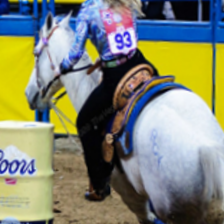

In [8]:
center_crop_224(T_inv_spatial(resize_322(T_spatial(resize_224(orig_img)))))

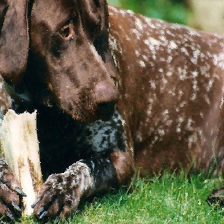

In [10]:
# current version
center_crop_224(T_inv_spatial(resize_322(T_spatial(resize_322(orig_img)))))

In [16]:
print(np.abs(np.array(tmp) - np.array(img1)).mean())


print(np.abs(np.array(tmp) - np.array(img2)).mean())

print(np.array(orig_img))

print(np.array(img2))

121.2990340667517
120.47715375212584
[[[ 32  25  16]
  [ 28  25  16]
  [ 25  28  20]
  ...
  [207 201 171]
  [207 201 169]
  [208 202 169]]

 [[ 34  27  17]
  [ 30  25  16]
  [ 28  26  19]
  ...
  [215 209 180]
  [213 207 177]
  [214 209 178]]

 [[ 35  27  18]
  [ 37  28  18]
  [ 32  25  17]
  ...
  [219 213 184]
  [216 211 182]
  [218 213 184]]

 ...

 [[ 46  58  40]
  [142 170 138]
  [145 161 146]
  ...
  [135 180  95]
  [108 149  55]
  [131 172  79]]

 [[ 87  94  72]
  [131 149 124]
  [117 123 119]
  ...
  [127 170  83]
  [109 151  59]
  [100 143  56]]

 [[150 148 118]
  [ 58  68  48]
  [ 17  20  12]
  ...
  [110 154  62]
  [ 92 136  49]
  [ 82 127  43]]]
[[[ 77  50  30]
  [ 77  50  30]
  [ 85  59  42]
  ...
  [143 113  98]
  [154 124 115]
  [164 139 136]]

 [[ 76  50  32]
  [ 80  55  37]
  [ 86  61  42]
  ...
  [143 113  98]
  [145 116  99]
  [164 139 136]]

 [[ 80  55  38]
  [ 80  55  38]
  [ 84  60  41]
  ...
  [151 124 107]
  [148 122 104]
  [148 121 101]]

 ...

 [[147 120 106]

In [37]:
with open("./val_seed_0.npy", "rb") as f:
    filepath_list = np.load(f)


img1_error = []
img2_error = []
for img_path in filepath_list:

    orig_img = Image.open(img_path)
    tmp = center_crop_224(resize_322(resize_224(Image.open(img_path))))
    
    # img1 = center_crop_224(T_inv_spatial(resize_322(resize_224(T_spatial(resize_322(orig_img))))))
    img2 = center_crop_224(T_inv_spatial(resize_322(T_spatial(resize_224(orig_img)))))
    
    # img1_error.append(np.abs(np.array(orig_img) - np.array(img1)))
    img2_error.append(np.abs(np.array(orig_img) - np.array(img2)))



128.01166355761055
127.72030637489371


In [12]:
attr, _ = expl_func(_orig_img, "init")
print(attr[0, 0, :, :])
attr = center_crop_224(LayerAttribution.interpolate(attr, (322, 322), 'bicubic'))
print(attr[0, 0, :, :])

attr = np.transpose(attr.squeeze(0).cpu().detach().numpy(), (1,2,0))

# print(attr)
# plt.imshow(attr, cmap="seismic")
# plt.colorbar()
# plt.show()
# print(attr.shape)
# print(torch.sum(attr))
# plt.imshow(attr)
# plt.colorbar()
# sttr = (attr - torch.min(attr)) / (torch.max(attr) - torch.min(attr))

# rint(attr)
_ = viz.visualize_image_attr(attr, np.transpose(center_cropped.squeeze().cpu().detach().numpy(), (1,2,0)), method="blended_heat_map", sign = 'all', show_colorbar=True, title = expl_method)

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED